<a href="https://colab.research.google.com/github/catherinemae0/DS4002-CaseStudy/blob/main/Scripts/ds4002p3movieanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Function Definitions

In [ ]:
#rm -r DS4002-P3/

In [1]:
! git clone https://github.com/SebastianWikt/DS4002-P3.git

Cloning into 'DS4002-P3'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 101 (delta 42), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 38.10 MiB | 8.94 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf


def loadData(file):
  # The column names are adopted from the dataset page on Kaggle
  df = pd.read_csv(file)
  return df

def plot_color_histograms(image_paths):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        colors = ('r', 'g', 'b')
        plt.figure(figsize=(10, 5))
        plt.title(f'Color Histogram for {os.path.basename(img_path)}')

        for i, color in enumerate(colors):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            plt.plot(hist, color=color)
            plt.xlim([0, 256])
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()

def check_color_channels(image_paths):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if len(img.shape) == 2:  # Grayscale images have 2 dimensions
            print(f'{os.path.basename(img_path)} is Grayscale')
        elif len(img.shape) == 3 and img.shape[2] == 3:  # RGB images have 3 dimensions
            print(f'{os.path.basename(img_path)} is RGB')
        else:
            print(f'{os.path.basename(img_path)} has an unusual format')

def check_image_quality(image_paths, min_resolution=(150, 150)):
    for img_path in image_paths:
        img = cv2.imread(img_path)
        # Check resolution
        height, width = img.shape[:2]
        if width < min_resolution[0] or height < min_resolution[1]:
            print(f'Low-resolution image: {os.path.basename(img_path)} - {width}x{height} pixels')

        # Check brightness (mean of pixel intensities)
        brightness = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).mean()
        print(f'{os.path.basename(img_path)} - Mean Brightness: {brightness:.2f}')

        # Check blur using Laplacian variance
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        if laplacian_var < 100:  # Threshold for blur detection (adjust as needed)
            print(f'Blurred image: {os.path.basename(img_path)} - Variance: {laplacian_var:.2f}')

def get_kernel_dimensions(version, shape, divisor):
    image_width = shape[1]

    # original
    if version == 1:
        return 3, 3

    # square 10% width
    if version == 2:
        return int(0.1 * image_width / divisor), int(0.1 * image_width / divisor)

    # square 20% width
    if version == 3:
        return int(0.2 * image_width / divisor), int(0.2 * image_width / divisor)

# Preprocessing Images

In [3]:
df = pd.read_csv('/content/DS4002-P3/Data/MoviePosterData.csv')
genre_horror = df[df['Genre'] == 'Horror']
genre_romance = df[df['Genre'] == 'Romance']
genre_comedy = df[df['Genre'] == 'Comedy']

In [4]:
import os
import requests
from PIL import Image, ImageStat
from io import BytesIO
import numpy as np
import cv2

folder_path = '/content/images'
os.makedirs(folder_path, exist_ok=True)

image_paths = []

for i, url in enumerate(df['MoviePoster']):
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))

        image = image.resize((106, 161), Image.Resampling.LANCZOS)


        image_filename = f"image_{i}.jpg"
        image_path = os.path.join(folder_path, image_filename)
        image.save(image_path)

        img = Image.open(image_path)

        # Get image size (width, height)
        width, height = img.size
        #print(f"Image size: {width}x{height}")

        image_paths.append(image_path)

        # print(f"Saved image_{i}.jpg")
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        image_paths.append(np.NaN)

df['LocalImagePath'] = image_paths

df = df.dropna(subset=['LocalImagePath']).reset_index(drop=True)

# Save the updated DataFrame back to a CSV
updated_csv_path = '/content/updated_movie_posters.csv'
df.to_csv(updated_csv_path, index=False)

Failed to download https://resizing.flixster.com/Z4rXSYbJQqbNeg98GALgj9Zr4Us=/fit-in/180x240/v2/https://resizing.flixster.com/F6uq33fFCuVQ60zCZav-IcpCW_c=/ems.cHJkLWVtcy1hc3NldHMvbW92aWVzLzY2ZTM5ZDZmLTUyZTUtNGY3ZC1iNzRkLTAyNzFlYWI4MGIxMS5wbmc=: cannot write mode RGBA as JPEG
Failed to download https://resizing.flixster.com/bIPZBZa19y6UeZFAGAh4WLTQSDk=/fit-in/180x240/v2/https://images.fandango.com/cms/assets/5d84d010-59b1-11ea-b175-791e911be53d--rt-poster-defaultgif.gif: cannot write mode P as JPEG


In [5]:
import os
import os
import shutil

# Organize images into subdirectories by Genre
for _, row in df.iterrows():
    genre = row['Genre']
    img_path = row['LocalImagePath']

    genre_folder = os.path.join(folder_path, genre)
    os.makedirs(genre_folder, exist_ok=True)
    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(genre_folder, os.path.basename(img_path)))
print(os.listdir('/content/images'))


['Romance', 'Horror', 'Comedy']


# Splitting Data

In [6]:
from sklearn.datasets import load_files
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils
# SWTIVCHED THIS

from keras.preprocessing import image
from tqdm import tqdm # progress bar
from functools import partial

data_dir = "/content/images/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model we choose, we will need to change these dimensions accordingly
img_height = 106;
img_width = 161;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 548 files belonging to 3 classes.
Using 439 files for training.
Found 548 files belonging to 3 classes.
Using 109 files for validation.


# Graphing


In [7]:
### GRAPHS FROM FULL DATA
image_folder = folder_path

# Get all image paths in the subdirectories
image_paths = []
for root, _, files in os.walk(image_folder):
    for file in files:
        image_paths.append(os.path.join(root, file))
print(image_paths)
#plot_color_histograms(image_paths)

['/content/images/Romance/image_75.jpg', '/content/images/Romance/image_46.jpg', '/content/images/Romance/image_150.jpg', '/content/images/Romance/image_133.jpg', '/content/images/Romance/image_42.jpg', '/content/images/Romance/image_188.jpg', '/content/images/Romance/image_171.jpg', '/content/images/Romance/image_34.jpg', '/content/images/Romance/image_62.jpg', '/content/images/Romance/image_88.jpg', '/content/images/Romance/image_41.jpg', '/content/images/Romance/image_137.jpg', '/content/images/Romance/image_15.jpg', '/content/images/Romance/image_199.jpg', '/content/images/Romance/image_40.jpg', '/content/images/Romance/image_140.jpg', '/content/images/Romance/image_25.jpg', '/content/images/Romance/image_196.jpg', '/content/images/Romance/image_193.jpg', '/content/images/Romance/image_9.jpg', '/content/images/Romance/image_1.jpg', '/content/images/Romance/image_181.jpg', '/content/images/Romance/image_91.jpg', '/content/images/Romance/image_119.jpg', '/content/images/Romance/image

In [8]:
# CHANGE TO FIT NEW SUBDIRECTORIES
# Calculating average image r,g,b and adding to dataframe
rgb_values = []

# Process each image by its path
for i, img_path in enumerate(image_paths):
    try:
        if i == 444 or i == 496:  # Skip specified indices
            rgb_values.append(np.NaN)
        else:
            img = Image.open(img_path)
            img = img.convert('RGB')  # Ensure image is in RGB format
            img_array = np.array(img)
            mean_rgb = img_array.mean(axis=(0, 1))  # Calculate mean RGB values for each image
            rgb_values.append(mean_rgb)

            # Update the DataFrame with RGB values
            df.loc[i, 'avg_r'] = mean_rgb[0]
            df.loc[i, 'avg_g'] = mean_rgb[1]
            df.loc[i, 'avg_b'] = mean_rgb[2]
    except FileNotFoundError:
        print(f"Image not found: {img_path}")
        rgb_values.append(np.NaN)  # Add NaN for missing images
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        rgb_values.append(np.NaN)

# Drop rows where RGB values are NaN
df.dropna(subset=['avg_r', 'avg_g', 'avg_b'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

df.head()

,Genre,MoviePoster,Movie Title,LocalImagePath,avg_r,avg_g,avg_b
0,Romance,https://m.media-amazon.com/images/M/MV5BYjA4MT...,Malena,/content/images/image_0.jpg,102.434607,83.986933,70.700398
1,Romance,https://m.media-amazon.com/images/M/MV5BOTNmYz...,Amélie,/content/images/image_1.jpg,206.223310,192.659498,191.508379
2,Romance,https://m.media-amazon.com/images/M/MV5BYTY3Mm...,A Very Long Engagement,/content/images/image_2.jpg,86.562639,80.800188,76.816712
3,Romance,https://m.media-amazon.com/images/M/MV5BN2Q4Nj...,In the Mood for Love,/content/images/image_3.jpg,93.607524,97.184988,111.047053
4,Romance,https://m.media-amazon.com/images/M/MV5BYjIyND...,The Curious Case of Benjamin Button,/content/images/image_4.jpg,146.938709,128.671804,103.416794


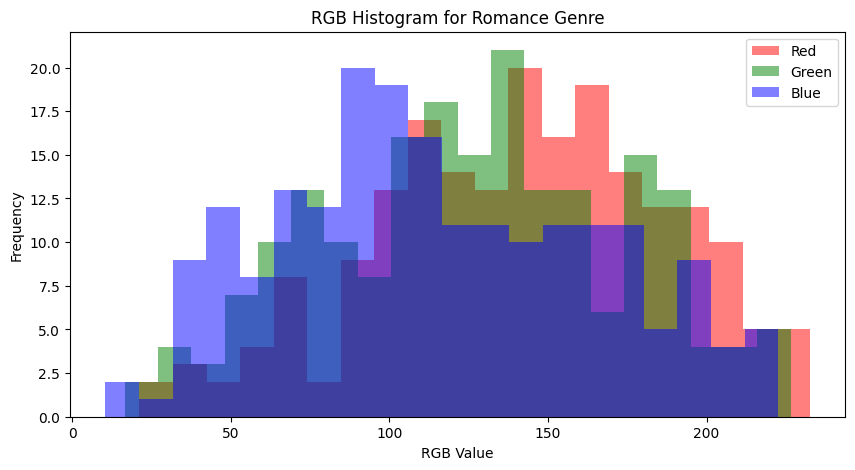

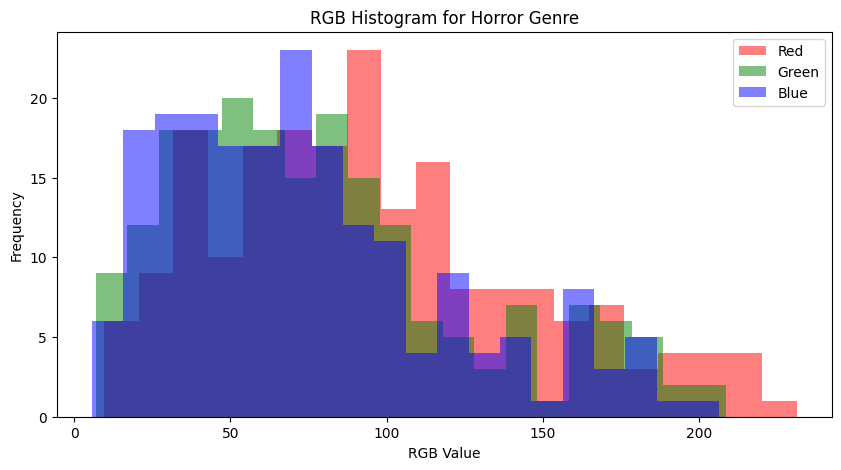

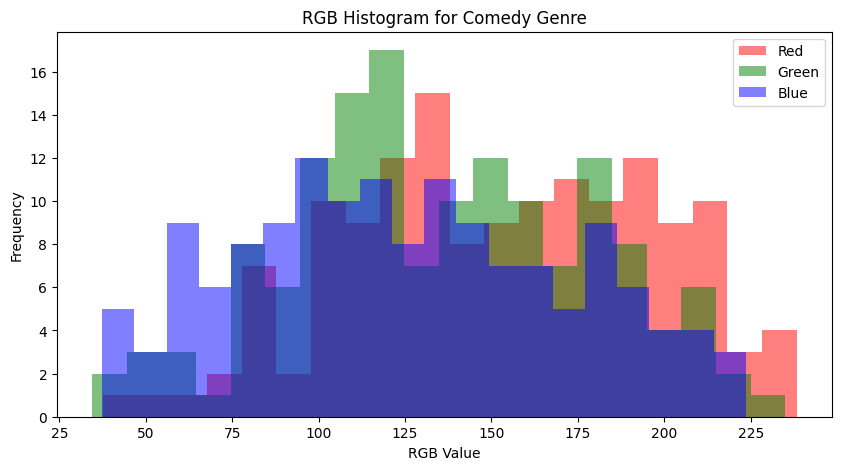

In [9]:
# Plotting a histogram of rgb values for each genre
for genre in df['Genre'].unique():
  genre_df = df[df['Genre'] == genre]
  plt.figure(figsize=(10, 5))
  plt.title(f'RGB Histogram for {genre} Genre')
  plt.hist(genre_df['avg_r'], bins=20, color='red', alpha=0.5, label='Red')
  plt.hist(genre_df['avg_g'], bins=20, color='green', alpha=0.5, label='Green')
  plt.hist(genre_df['avg_b'], bins=20, color='blue', alpha=0.5, label='Blue')
  plt.xlabel('RGB Value')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

In [10]:
# Calculating average image brightness and adding to dataframe
def brightness(im_file):
    im = Image.open(im_file).convert('L')  # Convert to grayscale
    stat = ImageStat.Stat(im)
    return stat.mean[0]

brightness_values = []

# Iterate over indices and search for images in subdirectories
for i in range(546):
    try:
        if i == 444 or i == 496:  # Skip specified indices
            brightness_values.append(np.NaN)
        else:
            # Search for the image in subdirectories
            found_image = False
            for subdir in os.listdir(image_folder):
                subdir_path = os.path.join(image_folder, subdir)
                if os.path.isdir(subdir_path):
                    img_path = os.path.join(subdir_path, f'image_{i}.jpg')
                    if os.path.exists(img_path):
                        found_image = True
                        break

            # If the image is found, calculate brightness
            if found_image:
                pbrightness = brightness(img_path)
                brightness_values.append(pbrightness)
            else:
                print(f"Image not found: {i}")
                brightness_values.append(np.NaN)

    except Exception as e:
        print(f"Error processing image_{i}: {e}")
        brightness_values.append(np.NaN)

# Assign brightness values to the DataFrame and drop NaN rows
df['brightness'] = brightness_values
df.dropna(subset=['brightness'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)
df.head()

,Genre,MoviePoster,Movie Title,LocalImagePath,avg_r,avg_g,avg_b,brightness
0,Romance,https://m.media-amazon.com/images/M/MV5BYjA4MT...,Malena,/content/images/image_0.jpg,102.434607,83.986933,70.700398,131.799367
1,Romance,https://m.media-amazon.com/images/M/MV5BOTNmYz...,Amélie,/content/images/image_1.jpg,206.223310,192.659498,191.508379,59.756123
2,Romance,https://m.media-amazon.com/images/M/MV5BYTY3Mm...,A Very Long Engagement,/content/images/image_2.jpg,86.562639,80.800188,76.816712,99.868042
3,Romance,https://m.media-amazon.com/images/M/MV5BN2Q4Nj...,In the Mood for Love,/content/images/image_3.jpg,93.607524,97.184988,111.047053,64.541134
4,Romance,https://m.media-amazon.com/images/M/MV5BYjIyND...,The Curious Case of Benjamin Button,/content/images/image_4.jpg,146.938709,128.671804,103.416794,84.256123


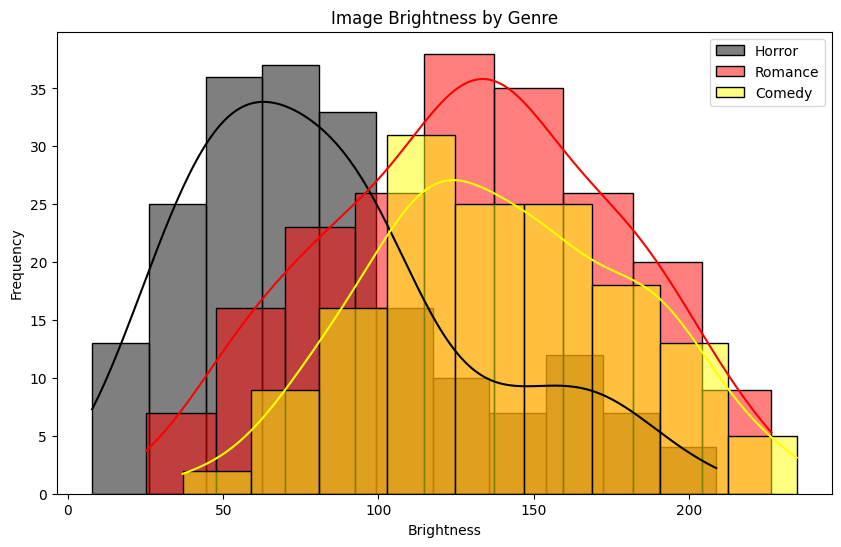

In [11]:
# Plotting a histogram of brightness grouped by genre

plt.figure(figsize=(10, 6))

sns.histplot(df[df['Genre'] == 'Horror']['brightness'], color='black', label='Horror', kde=True)
sns.histplot(df[df['Genre'] == 'Romance']['brightness'], color='red', label='Romance', kde=True)
sns.histplot(df[df['Genre'] == 'Comedy']['brightness'], color='yellow', label='Comedy', kde=True)


plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Image Brightness by Genre')
plt.legend()
plt.show()

# Model Building


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 140 x 207 to 106 x 161

num_classes = 3
kernel_dimensions1 = (3, 3)
kernel_dimensions2 = (2, 2)

model = Sequential([
      Conv2D(32, kernel_dimensions1, padding='same', input_shape=(106, 161, 3), activation='relu'),
      Conv2D(32, kernel_dimensions1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(64, kernel_dimensions2, padding='same', activation='relu'),
      Conv2D(64, kernel_dimensions2, activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax')
  ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
myEpochs = 3##TODO
myOptimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
myLoss = 'sparse_categorical_crossentropy'#TODO
myMetrics = ['accuracy']#TODO keep in mind that this can be multiple metrics including at least the accuracy
model.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = model.fit(train_ds, validation_data=validation_ds, epochs = myEpochs)
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

Epoch 1/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 711ms/step - accuracy: 0.3672 - loss: 49.2950 - val_accuracy: 0.3578 - val_loss: 1.0976
Epoch 2/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.3320 - loss: 1.0991 - val_accuracy: 0.3578 - val_loss: 1.0958
Epoch 3/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2995 - loss: 1.0965 - val_accuracy: 0.4587 - val_loss: 1.0932
